In [1]:
import cv2
import numpy as np
from pycocotools.coco import COCO
from skimage import io
import os
from config import config
from transformer import Transformer, AugmentSelection
from matplotlib import pyplot as plt

ANNO_FILE = config.VAL_ANNO_FILE
IMG_DIR = config.VAL_IMG_DIR

In [2]:
coco = COCO(ANNO_FILE)
img_ids = list(coco.imgs.keys())
datasetlen = len(img_ids)
id = 0

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


[[477, 243, 2, 492, 225, 2, 461, 224, 2, 510, 218, 2, 420, 204, 2, 525, 286, 2, 393, 287, 2, 544, 361, 2, 378, 366, 2, 514, 374, 2, 430, 382, 2, 508, 442, 2, 420, 441, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[477, 243, 2, 492, 225, 2, 461, 224, 2, 510, 218, 2, 420, 204, 2, 525, 286, 2, 393, 287, 2, 544, 361, 2, 378, 366, 2, 514, 374, 2, 430, 382, 2, 508, 442, 2, 420, 441, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [156, 261, 2, 175, 234, 2, 131, 241, 2, 218, 223, 2, 105, 230, 2, 225, 285, 2, 79, 295, 2, 264, 333, 2, 55, 360, 2, 276, 397, 2, 47, 447, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


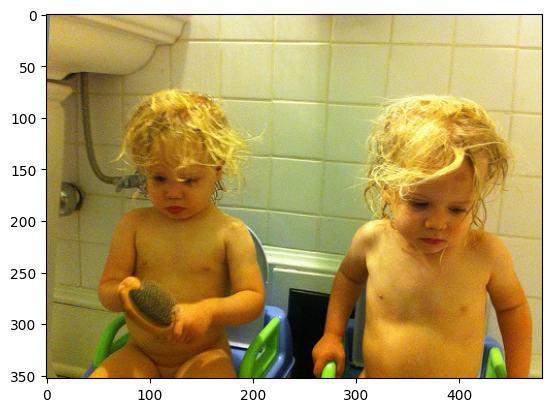

In [3]:
#patient monitoring 355257
#person 508730
#no person 113403
img_id = 508730
filepath = os.path.join(IMG_DIR,coco.imgs[img_id]['file_name'])
img = cv2.imread(filepath)
h, w, c = img.shape

keypoints = []
instance_masks = []
img_anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
crowd_mask = np.zeros((h,w), dtype='bool')
unannotated_mask = np.zeros((h,w), dtype='bool')

for anno in img_anns:
    mask = coco.annToMask(anno)
    
    if anno['iscrowd'] == 1:
        crowd_mask = np.logical_or(crowd_mask, mask)
    elif anno['num_keypoints'] == 0 :
        unannotated_mask = np.logical_or(unannotated_mask, mask)
        instance_masks.append(mask)
        keypoints.append(anno['keypoints'])
    else:
        instance_masks.append(mask)
        keypoints.append(anno['keypoints'])
        print(keypoints)

kp = np.reshape(keypoints, (-1, config.NUM_KP, 3))

instance_masks = np.stack(instance_masks).transpose((1,2,0))
overlap_mask = instance_masks.sum(axis=-1) > 1
seg_mask = np.logical_or(crowd_mask, np.sum(instance_masks, axis=-1))
single_masks = [seg_mask, unannotated_mask, crowd_mask, overlap_mask]
all_masks = np.concatenate([np.stack(single_masks, axis=-1), instance_masks], axis=-1)

aug = AugmentSelection.random()
img, all_masks, kp = Transformer.transform(img, all_masks, kp, aug=aug)

plt.imshow(img[:,:,[2,1,0]])

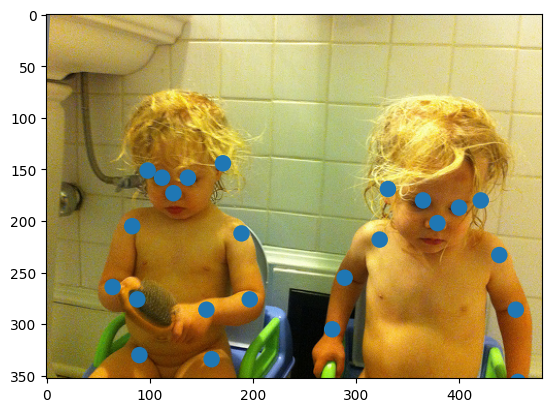

In [4]:
from matplotlib.patches import Circle
fig,ax = plt.subplots(1)
# Show the image
ax.imshow(img[:,:,[2,1,0]])
keypoints = kp[:,:,[0,1]]
for i in range(2):
    for j in range(17):
        if all(keypoints[i][j]) is not False:
            circ = Circle(keypoints[i][j],8)
            ax.add_patch(circ)
plt.show()

### Creating index

1. **np.indices**:

            np.indices(3,3) : will create 2,3,3
                    [[[0, 0, 0]
                      [1, 1, 1]
                      [2, 2, 2]]
                      
                     [[0, 1, 2]
                       0, 1, 2]
                       0, 1, 2]]]                

2. **rollaxis** 
         
            np.rollaxis(np.indices(3,3), 0 , 3): will create 3, 3, 2
                    [[[0, 0]
                      [0, 1]
                      [0, 2]]
               
                     [[1, 0]
                      [1, 1]
                      [1, 2]]
               
                     [[2, 0]
                      [2, 1]
                      [2, 2]]]
                
3. **Finally transpose resultant matrix to get index points**
        
        np.rollaxis(np.indices(3,3), 0 , 3).transpose(1, 0, 2):
                    [[[0, 0]
                      [1, 0]
                      [2, 0]]
              
                     [[0, 1]
                      [1, 1]
                      [2, 1]]
              
                    [[0, 2]
                     [1, 2]
                     [2, 2]]]

            

In [5]:
map_shape = (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
idx = np.rollaxis(np.indices(map_shape[::-1]), 0, 3).transpose((1,0,2))

### sample for one discs calculation
subtracting each point coordinates with center and take square then sum the 1D elements and take square root of the elments
    
    let imagine we have a shape of 3,3 and take center as 2,2
    (center - idx)^2 => [[[4 4] 
                          [1 4] 
                          [0 4]]
                         [[4 1]
                          [1 1]
                          [0 1]]
                         [[4 0]
                          [1 0]
                          [0 0]]]
    (center- idx)^2.sum(axis = -1) => we sum row values => take square root
                       [[8 5 4]                       [[2.82842712 2.23606798 2.]
                        [5 2 1]      =>                [2.23606798 1.41421356 1.]
                        [4 1 0]]                       [2.         1.         0.]]
                

In [6]:
discs = [[] for _ in range(len(kp))]
for i in range(config.NUM_KP):  
    centers = [keypoints[i,:2] for keypoints in kp if keypoints[i,2] > 0]
    dists = np.zeros(map_shape+(len(centers),))
    
    #distance calculation from keypoint to all point coordinates
    for k, center in enumerate(centers):
        # based on number of centers per keypoint, we are calculating distance from the center
        dists[:,:,k] = np.sqrt(np.square(center-idx).sum(axis=-1))
        
    if len(centers) > 0:
        #create a input shape matrix which has index of minimum value among the rows of all dists per keypoint
        inst_id = dists.argmin(axis=-1)
            
    count = 0
    # Iterate through keypoints pairs(kp1 of 17, kp2 of 17) then create a boolean matrix
    for j in range(len(kp)): 
        if kp[j][i,2] > 0:
            discs[j].append(np.logical_and(inst_id==count, dists[:,:,count]<=config.KP_RADIUS))
            count +=1
        else:
            discs[j].append(np.array([]))

kp_maps = np.zeros(map_shape+(config.NUM_KP,))
for i in range(config.NUM_KP):
    for j in range(len(discs)):
        if kp[j][i,2] > 0:
            kp_maps[discs[j][i], i] = 1.

In [7]:
# To understand disc formation and heatmap geneatation
import numpy as np

input_shape = (10, 10)
l_r = 2
l_discs= [[] for _ in range(2)]
l_idx = np.rollaxis(np.indices(input_shape), 0, 3).transpose(1,0,2)

l_center = [(3,3),(6,6)]
l_dist  = np.zeros(input_shape+(len(l_center),))

#distance calculation 
l_dist[:,:,0] = np.sqrt(np.square(l_center[0]-l_idx).sum(axis=-1))
l_dist[:,:,1] = np.sqrt(np.square(l_center[1]-l_idx).sum(axis=-1))

inst_id = l_dist.argmin(axis=-1)
l_discs[0].append(np.logical_and(inst_id==0 , l_dist[:,:,0]<=l_r))
l_discs[1].append(np.logical_and(inst_id==1 , l_dist[:,:,1]<=l_r))

print(l_dist)
print("-----------------------------------------")
print(l_dist[:,:,1])
print("-----------------------------------------")
print(inst_id)
print("-----------------------------------------")
print(inst_id==1)
print("-----------------------------------------")
print (l_dist[:,:,1]<=1)
print("-----------------------------------------")
print("create matrix with center (3,3) and surrounding pixel with radius of "+str(l_r)+" as true and remaining values are false")
print(np.logical_and(inst_id==1 , l_dist[:,:,1]<=1))
print("-----------------------------------------")
print("Generated Heatmap for keypoint 0")
l_maps = np.zeros(input_shape+(17,))
l_maps[l_discs[0][0], 0] = 1.
l_maps[l_discs[1][0], 0] = 1.

print(l_maps[:,:,0])

[[[4.24264069 8.48528137]
  [3.60555128 7.81024968]
  [3.16227766 7.21110255]
  [3.         6.70820393]
  [3.16227766 6.32455532]
  [3.60555128 6.08276253]
  [4.24264069 6.        ]
  [5.         6.08276253]
  [5.83095189 6.32455532]
  [6.70820393 6.70820393]]

 [[3.60555128 7.81024968]
  [2.82842712 7.07106781]
  [2.23606798 6.40312424]
  [2.         5.83095189]
  [2.23606798 5.38516481]
  [2.82842712 5.09901951]
  [3.60555128 5.        ]
  [4.47213595 5.09901951]
  [5.38516481 5.38516481]
  [6.32455532 5.83095189]]

 [[3.16227766 7.21110255]
  [2.23606798 6.40312424]
  [1.41421356 5.65685425]
  [1.         5.        ]
  [1.41421356 4.47213595]
  [2.23606798 4.12310563]
  [3.16227766 4.        ]
  [4.12310563 4.12310563]
  [5.09901951 4.47213595]
  [6.08276253 5.        ]]

 [[3.         6.70820393]
  [2.         5.83095189]
  [1.         5.        ]
  [0.         4.24264069]
  [1.         3.60555128]
  [2.         3.16227766]
  [3.         3.        ]
  [4.         3.16227766]
  [5. 

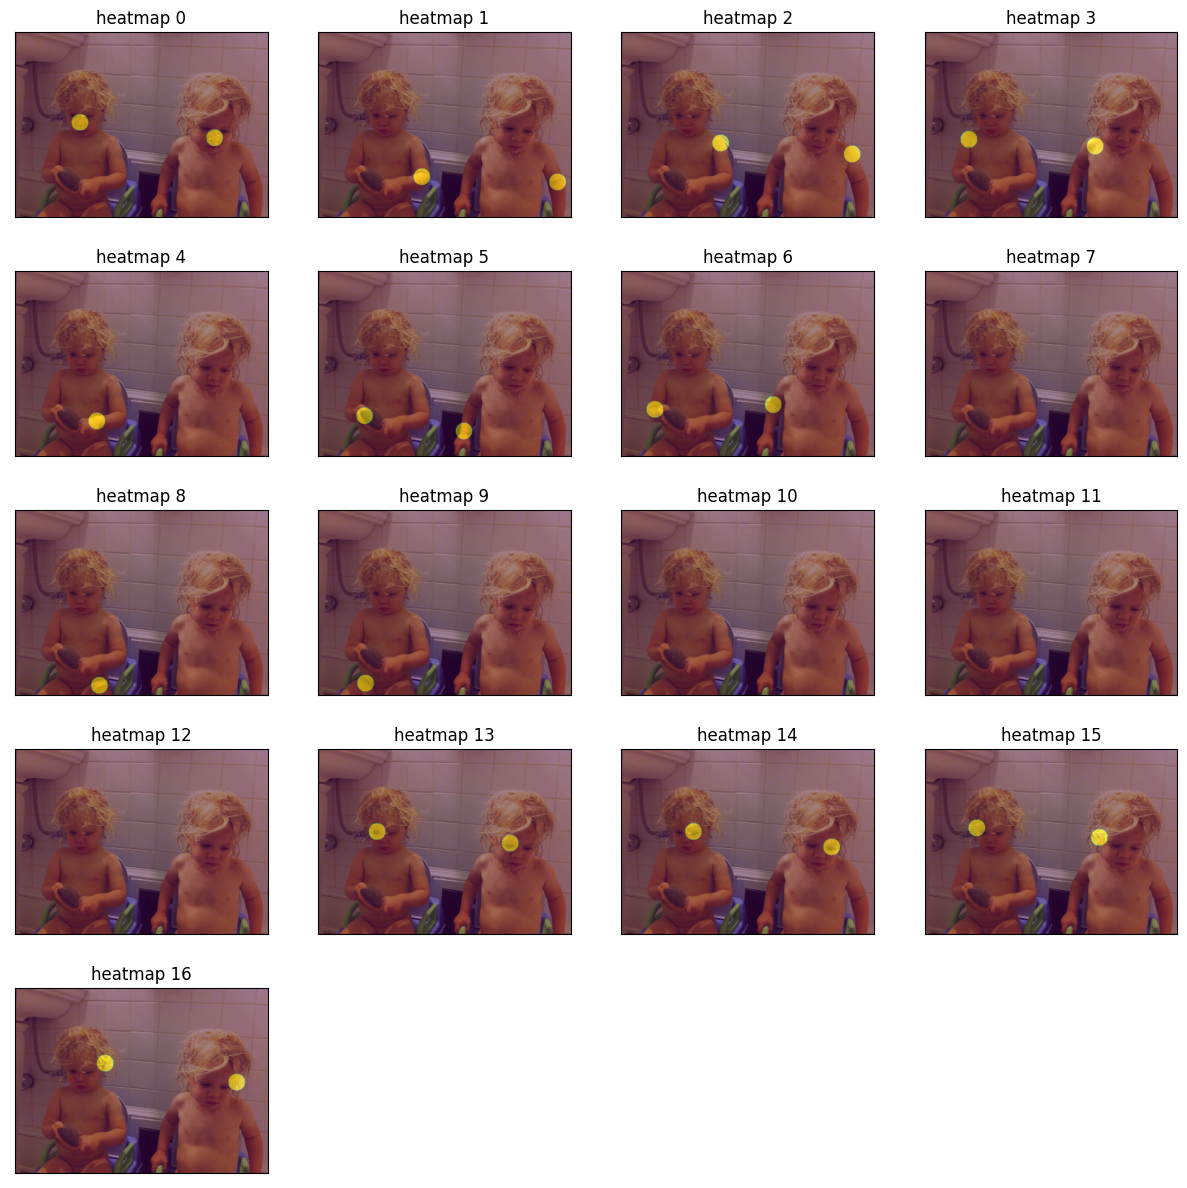

In [8]:
figure = plt.figure(figsize=(15, 15))
for i in range(17):
    plt.subplot(5, 4, i+1, title='heatmap {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[:,:,[2,1,0]])
    plt.imshow(kp_maps[:, :, i],alpha=0.5)

In [9]:
# To understand kp_circle generation:
l_x =np.tile(np.arange(l_r, -l_r-1, -1), [2*l_r+1, 1])
l_y = l_x.T
l_m = np.sqrt(l_x*l_x +l_y*l_y) <= l_r # -> boolean value 
lm_kp_circle = np.stack([l_x, l_y], axis=-1) * np.expand_dims(l_m, axis=-1) 

print("-----------------------------------------")
print(l_x)
print("-----------------------------------------")
print(l_y)
print("-----------------------------------------")
print(lm_kp_circle.transpose(2,1,0))
print(lm_kp_circle.shape)
l_offsets = np.zeros(input_shape+(2*17,))

-----------------------------------------
[[ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]]
-----------------------------------------
[[ 2  2  2  2  2]
 [ 1  1  1  1  1]
 [ 0  0  0  0  0]
 [-1 -1 -1 -1 -1]
 [-2 -2 -2 -2 -2]]
-----------------------------------------
[[[ 0  0  2  0  0]
  [ 0  1  1  1  0]
  [ 0  0  0  0  0]
  [ 0 -1 -1 -1  0]
  [ 0  0 -2  0  0]]

 [[ 0  0  0  0  0]
  [ 0  1  0 -1  0]
  [ 2  1  0 -1 -2]
  [ 0  1  0 -1  0]
  [ 0  0  0  0  0]]]
(5, 5, 2)


In [10]:
from sympy import Matrix, init_printing
init_printing()

In [13]:
def l_copy_with_border_check(map, center, disc, lm_kp_circle, l_r, input_shape):
    r=l_r
    input_shape=input_shape
    from_top = max(r-center[1], 0)
    from_left = max(r-center[0], 0)
    from_bottom = max(r-(input_shape[0]-center[1])+1, 0)
    from_right =  max(r-(input_shape[1]-center[0])+1, 0)
        
    cropped_disc =  disc[center[1] - r + from_top : center[1]  + r + 1 - from_bottom, 
                         center[0] - r + from_left: center[0]  + r  +1  - from_right]
    #print(cropped_disc)
    map[center[1] -r + from_top : center[1] + r + 1 - from_bottom, 
        center[0]- r + from_left: center[0] + r + 1 - from_right, :][cropped_disc,:] = \
      lm_kp_circle[from_top : 2 * r + 1 - from_bottom, 
                from_left: 2 * r + 1 -from_right, :][cropped_disc,:]

In [14]:
l_copy_with_border_check(l_offsets[:,:,0:2], (l_center[1][0], l_center[1][1]), l_discs[1][0], lm_kp_circle, l_r , input_shape)
l_copy_with_border_check(l_offsets[:,:,0:2], (l_center[0][0], l_center[0][1]), l_discs[0][0], lm_kp_circle,l_r , input_shape)
print("----------------------------")
print(l_offsets[:,:,0])
print("----------------------------")
print(l_offsets[:,:,1])

----------------------------
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  2.  1.  0. -1. -2.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  2.  1.  0. -1. -2.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
----------------------------
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0.  2.  0.  0.  0.]
 [ 0.  0.  0. -2.  0.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [17]:
r = config.KP_RADIUS
x = np.tile(np.arange(r, -r-1, -1), [2*r+1, 1])
y = x.transpose()
m = np.tile(np.arange(r, -r-1, -1), [2*r+1, 1])
kp_circle = np.stack([x, y], axis=-1) * np.expand_dims(m, axis=-1)

def copy_with_border_check(map, center, disc):
    from_top = max(r-center[1], 0)
    from_left = max(r-center[0], 0)
    from_bottom = max(r-(map_shape[0]-center[1])+1, 0)
    from_right =  max(r-(map_shape[1]-center[0])+1, 0)
        
    cropped_disc =  disc[center[1] - r + from_top : center[1] + r + 1 -from_bottom, 
                         center[0] - r + from_left: center[0] + r + 1 -from_right]
    
    map[center[1] -r + from_top : center[1] + r + 1 - from_bottom, 
        center[0]- r + from_left: center[0] + r + 1 - from_right, :][cropped_disc,:] = \
      kp_circle[from_top : 2 * r + 1 - from_bottom, 
                from_left: 2 * r + 1 -from_right, :][cropped_disc,:]
    return map

short_offsets = np.zeros(map_shape+(2*config.NUM_KP,))
for i in range(config.NUM_KP):
    for j in range(len(kp)):
        if kp[j][i,2] > 0:                                           #offsets[:, :, 2 * i : 2 * i + 2]          
            short_offsets[:, :,  [i ,17+i]] = copy_with_border_check(short_offsets[:, :,  [i ,17+i]], (kp[j][i,0], kp[j][i,1]), discs[j][i])

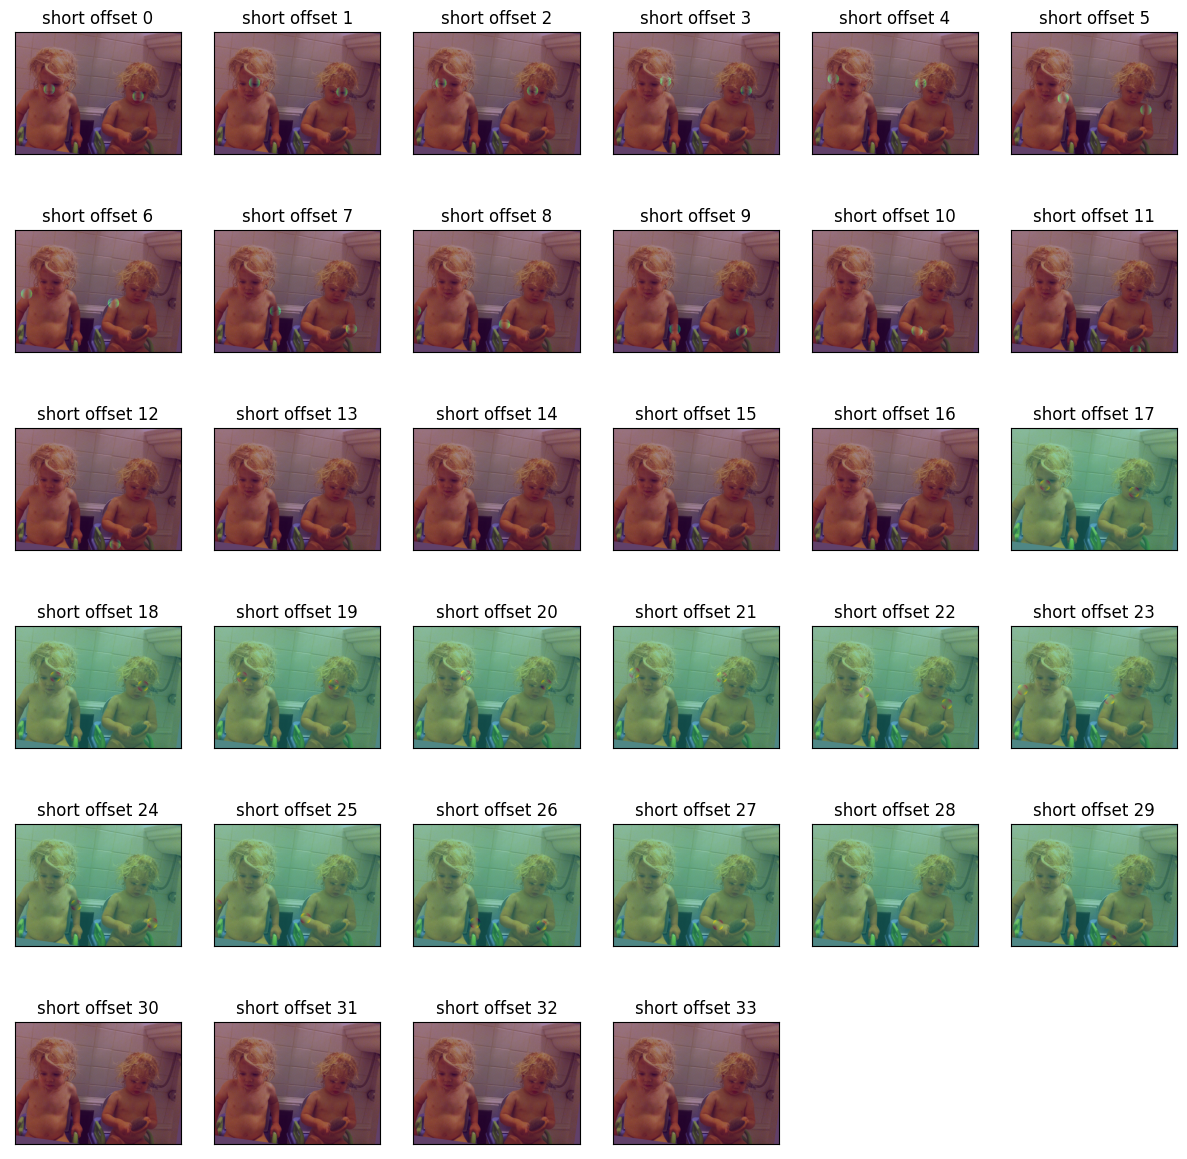

In [18]:
figure = plt.figure(figsize=(15,15))
for i in range(34):
    plt.subplot(6,6, i+1, title='short offset {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[:,:,[2,1,0]])
    plt.imshow(short_offsets[:, :, i],alpha=0.5)
    

In [19]:
(config.EDGES + [edge[::-1] for edge in config.EDGES])

In [20]:
mid_offsets = np.zeros(map_shape + (4 * config.NUM_EDGES,))
for i, edge in enumerate((config.EDGES + [edge[::-1] for edge in config.EDGES])):
    for j in range(len(kp)):
        if kp[j][edge[0],2] > 0 and kp[j][edge[1],2] > 0:
            m = discs[j][edge[0]]
            dists = [[ kp[j][edge[1],0], kp[j][edge[1],1] ]] - idx[m,:]
            # 2*i:2*i+2
            mid_offsets[m,2*i:2*i+2] = dists

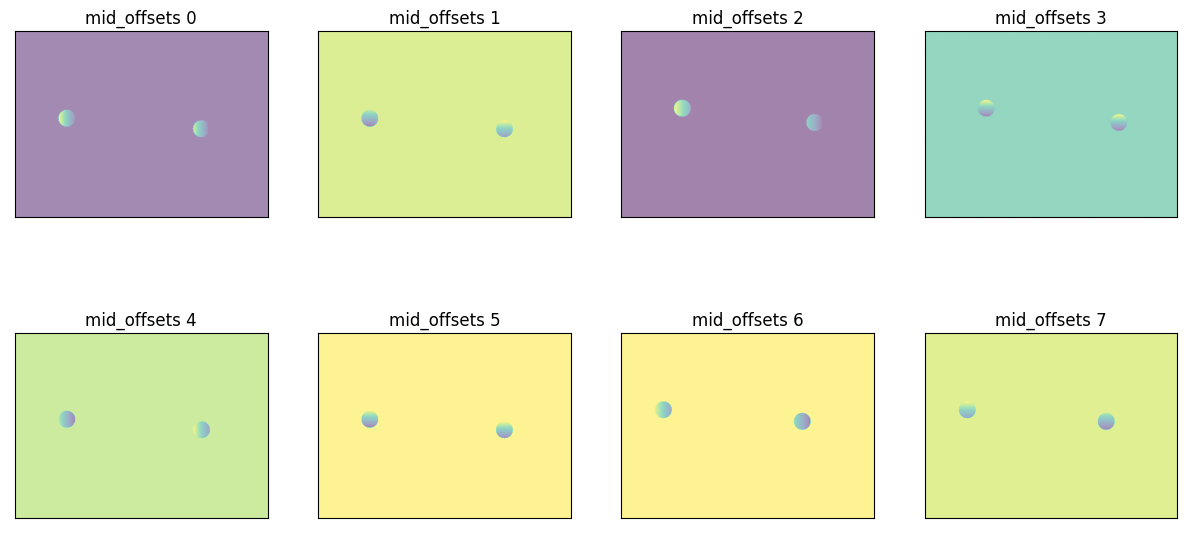

In [21]:
figure = plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(4,4, i+1, title='mid_offsets {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(img[:,:,[2,1,0]])
    plt.imshow(mid_offsets[:, :, i],alpha=0.5)